In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [8]:
connection = sqlite3.connect("./Data/db2assign2.db")

In [9]:
# Column names
dept_names = ["Department_ID", "Department_Name", "DOE"]
empl_names = ["Employee_ID", "DOB", "DOJ", "Department_ID"]
cncl_names = ["Student_ID", "DOA", "DOB", "Department_Choices", "Department_Admission"]
perf_names = ["Student_ID", "Semster_Name", "Paper_ID", "Paper_Name", "Marks", "Effort_Hours"]

# Change data types
perf_dtype = {"Marks": "INT", "Effort_Hours": "INT"}

# Read in csv data
pd.read_csv('./Data/Department_Information.csv', header=0, names=dept_names
           ).to_sql("deptInfo", connection, if_exists='replace', index=True)
pd.read_csv('./Data/Employee_Information.csv', header=0, names=empl_names
           ).to_sql("employInfo", connection, if_exists='replace', index=True)
pd.read_csv('./Data/Student_Counceling_Information.csv', header=0, names=cncl_names
           ).to_sql("studentCounselling", connection, if_exists='replace', index=True)
pd.read_csv('./Data/Student_Performance_Data.csv', header=0, names=perf_names
           ).to_sql("studentPerformance", connection, if_exists='replace', index=True, dtype=perf_dtype)

# SQLite only has the datatypes NULL, INTEGER, REAL (float), TEXT, and BLOB.
# Dates can use the SQLite builtin date functions, see https://sqlite.org/lang_datefunc.html

209610

In [10]:
# Validate, clean, and report issues

dept_df = pd.read_sql_query("SELECT * FROM deptInfo", connection)
empl_df = pd.read_sql_query("SELECT * FROM employInfo", connection)
cncl_df = pd.read_sql_query("SELECT * FROM studentCounselling", connection)
perf_df = pd.read_sql_query("SELECT * FROM studentPerformance", connection)

# deptInfo

# Missing values report
#print(dept_df[dept_df.isna().any(axis=1)])

# Department_ID uniqueness
#print(dept_df[dept_df.duplicated(subset=["Department_ID"], keep=False)])

# Department_Name uniqueness
#print(dept_df[dept_df.duplicated(subset=["Department_Name"], keep=False)])

# DOE > 1900
#ref_date = pd.Timestamp("1900-01-01")
#all_dates = pd.to_datetime(dept_df['DOE'], format="%m/%d/%Y", errors="coerce")
#print(dept_df[all_dates.isna() | (all_dates < ref_date)])


# studentCounselling

# Missing values report
#print(cncl_df[cncl_df.isna().any(axis=1)])

# Department_Admission does not exist in dept_df
#print(~cncl_df['Department_Admission'].isin(dept_df['Department_ID']))



#exceptions = {}

#def log_exception(df, name):
#    if not df.empty:
#        exceptions[name] = df
#        print(f"[!] {len(df)} issue(s) found in {name}")
#    else: 
#        print(f"[OK] {name} - no issues found")

#log_exception(df1, 'Department_ID')

In [11]:
# Join cleaned Student performance to counceling to department info for future data mining

#master_df = pd.merge(perf_df, cncl_df, on=['Student_ID','Student_ID'])
#master_df = pd.merge(master_df, dept_df on=['Department_Admission','Department_ID'])


In [13]:
df1 = pd.read_sql_query("SELECT * FROM deptInfo", connection)
df2 = pd.read_sql_query("SELECT Effort_Hours, Marks FROM studentPerformance", connection)

<AxesSubplot: title={'center': 'Plot of Effort/Mark achieved'}, xlabel='Marks', ylabel='Effort_Hours'>

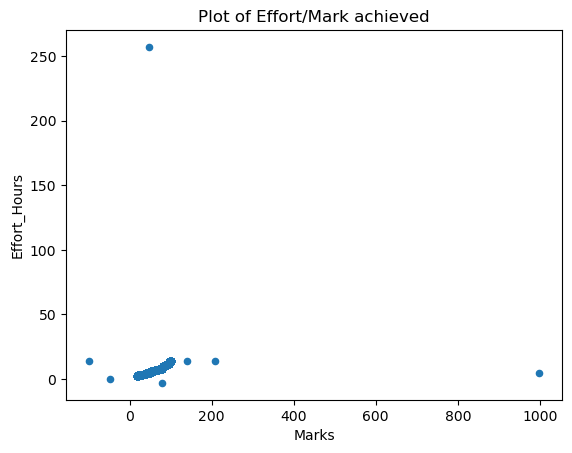

In [14]:
df2.plot.scatter(x='Marks', y='Effort_Hours', title='Plot of Effort/Mark achieved')

In [91]:
# print(df2.corr())
# anything above 0.8 is considered 'high' according to LinRegmin
# we can use this loop to test any two column dataframe for correlations
corrTest = df2.corr()
for col1 in corrTest.columns:
    for col2 in corrTest.columns:
        if col1 != col2 and abs(corrTest.loc[col1, col2]) > 0.8:
            print(f"{col1} vs {col2}: {corrTest.loc[col1, col2]:.3f}")

Effort_Hours vs Marks: 0.940
Marks vs Effort_Hours: 0.940


In [92]:
# This takes a dataframe with numerical entries and groups them together
# SHOULD work with multiple columns?
def print_correlations(dataf, threshold):
    corr_test = dataf.corr(numeric_only=True)
    checked = set()

    for col1 in corr_test.columns:
        for col2 in corr_test.columns:
            if col1 != col2 and (col2, col1) not in checked:
                correlation = corr_test.loc[col1, col2]
                if abs(correlation) > threshold:
                    print(f"[{col1}:{col2}:{correlation:.3f}]")
                checked.add((col1, col2))
print(print_correlations(df2,0.8))

[Effort_Hours:Marks:0.940]
None


predictions:
Supplied Effort_Hours =32.00 
Predicted Marks = 221.91
Accuracy: 69.96%


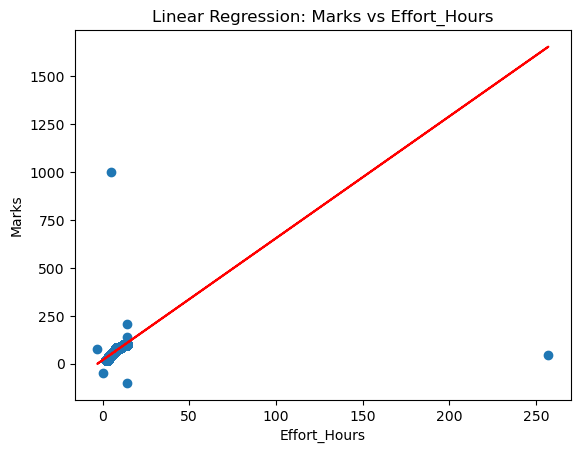

In [56]:
#take a dataframe with two columns, split them, run linear regression, predict and/or plot things
def lin_reg(dataf, xcol, ycol, predict=None, plot=True):
    dataf = dataf.dropna() # drops NaN entries
    # col1, col2 = dataf.columns
    y=dataf[ycol].values.reshape(-1,1)
    # print(y.shape) # Testing
    x=dataf[xcol].values.reshape(-1,1)
    # print(x.shape) # Testing
    x_train, x_test, y_train, y_test = train_test_split(x ,y, test_size=0.2, random_state=42)
    regressor=LinearRegression()
    regressor.fit(x_train, y_train)
    if predict is not None:
        predict = np.array(predict).reshape(-1,1)
        predicted_y = regressor.predict(predict)
        print("predictions:")
        for i, val in enumerate(predict.flatten()):
            print(f"Supplied {xcol} ={val:.2f} \nPredicted {ycol} = {predicted_y[i][0]:.2f}")
    if plot:
        plt.scatter(x, y)
        plt.plot(x, regressor.predict(x), color='red')
        plt.title(f"Linear Regression: {ycol} vs {xcol}")
        plt.xlabel(xcol)
        plt.ylabel(ycol)
    print(f"Accuracy: {regressor.score(x_test, y_test)*100:.2f}%")
    
lin_reg(df2, 'Effort_Hours', 'Marks', 32, True)